<a href="https://colab.research.google.com/github/arjygh/stocksandoptions/blob/Working_AG/TA-options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#optional installations: 
!pip install yfinance --upgrade --no-cache-dir
# !pip3 install pandas_datareader
# !pip3 install matplotlib


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import ssl
from urllib import request
#dummy change


#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()

%matplotlib inline

     |████████████████████████████████| 5.5MB 9.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=be5f2bd9db4c9037b2fff5752f273d6abfb534d1ccd4adc5b42b86bad307db89
  Stored in directory: /tmp/pip-ephem-wheel-cache-i36c9jpd/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [84]:
def computeRSI (dataframe, time_window):
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
#     plt.plot(df.Date, macd, label='MACD', color = '#EBD2BE')
#     plt.plot(df.Date, exp3, label='Signal Line', color='#E5A4CB')
#     plt.legend(loc='upper left')
#     plt.show()
    return df

def CBI_func(ticker,start_time, end_time,trade_date_delta):
    # df = dataframe.copy()
    # day30 = df['Date'].iloc[-30]
    # start_time = datetime.datetime(2017, 10, 1)
    # #end_time = datetime.datetime(2019, 1, 20)
    # end_time = datetime.datetime.now().date().isoformat() 
    # start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
    # end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
    # print("Start Date: ", start_time)
    # print("End Date: ", end_time )
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            # ticker_df = pdr.get_data_yahoo(ticker, start=start_time, end=end_time)
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            # ticker_df = data.DataReader(ticker, 'google',start=start_time, end=end_time)
            connected = True
            # print('connected to yahoo')
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            # time.sleep( 5 )
            continue 

    # use numerical integer index instead of date    
    ticker_df = ticker_df.reset_index()
    # print(ticker_df.head(5))
    df0 = ticker_df
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0,'Close',12,26,9)
    

    

    day0 = df0['Date'].iloc[-1*trade_date_delta] #trade date
    # day1 = df['Date'].iloc[-1*slope1_delta]
    # day2 = df['Date'].iloc[-1*slope2_delta]
    print("Trade Date = ", day0)
    trade_date_price = df0['Close'].iloc[-1*trade_date_delta]
    holding_days = min(7,trade_date_delta)
    mask = df0['Date'].between(day0,(day0.date() + datetime.timedelta(days = holding_days)).isoformat())
    max_price = df0.loc[mask,'Close'].max()
    
    Price_delta = 100*(max_price - trade_date_price)/trade_date_price
    df = df0[(df0["Date"] <= day0)]
    # print("max_price: ", max_price)
    # print("price delta: ", Price_delta)

    # print(df0)
    # print(df)

    
    # print('df:',df)
    # max_price_30day = df.loc[1:30, 'Close'].max()
    

    CBIL = [] #Call Buying Indicator List
    CBIL.append(day0)

    avg_volume = avg_volume_in_window(df, 15, day0)
    
    #trade date values
    RSI_val = df[df['Date']==day0]['RSI'].values
    MACD_Div_val = df[df['Date']==day0]['MACD_Div'].values
    d_slow_val = df[df['Date']==day0]['d_slow'].values

    
    #slopes
    RSI_fit = slope_calculator(df, 7, day0,'RSI')
    MACD_Div_fit = slope_calculator(df,3,day0,'MACD_Div')
    d_slow_fit = slope_calculator(df,3,day0,'d_slow')


    vol_limit = 2e5

    if avg_volume > vol_limit and RSI_val > 45 and RSI_val < 75:

      # #RSI values: 
      # AllRSI = np.array([df[df['Date']==day0]['RSI'].values,df[df['Date']==day1]['RSI'].values,df[df['Date']==day2]['RSI'].values])
      # #d_slow values: 
      # AllSS = np.array([df[df['Date']==day0]['d_slow'].values,df[df['Date']==day1]['d_slow'].values,df[df['Date']==day2]['d_slow'].values])
      # #d_fast values
      # AllSF = np.array([df[df['Date']==day0]['d_fast'].values,df[df['Date']==day1]['d_fast'].values,df[df['Date']==day2]['d_fast'].values])
      # #d_div values
      # AllSD = np.array([df[df['Date']==day0]['d_div'].values,df[df['Date']==day1]['d_div'].values,df[df['Date']==day2]['d_div'].values])
      # #MACD_Div values
      # AllMD = np.array([df[df['Date']==day0]['MACD_Div'].values,df[df['Date']==day1]['MACD_Div'].values,df[df['Date']==day2]['MACD_Div'].values])

      # row = df[df['Date']==end_time]['d_slow'].values
      # print(df['Date'].iloc[-1])
      # print(AllRSI, AllSS, AllSF, AllMD)

      #Algorithm for entry ot exit
    

      #RSI Score
      # if AllRSI[0] > 50 and AllRSI[0] < 75:
      #   CBIL.append((abs(AllRSI[0] - 50)/25).item())
      # else: 
      #   CBIL.append(1.0)
      
      ##SS score
      # SS7DayDiv = AllSS[0] - AllSS[1] #use only when there is an increasing trend
      # if AllSS[0] > 20 and AllSS[0]< 40 and SS7DayDiv > 0:
      #   CBIL.append((abs(AllSS[0]-30)/10).item())
      # else:
      #   CBIL.append(1.0)
      if d_slow_val > 20 and d_slow_val < 40 and d_slow_fit[0] > 0:
        CBIL.append((abs(AllSS[0]-30)/10).item())
      else: 
        CBIL.append(1.0)

      if MACD_Div_val < 0 and MACD_Div_fit[1] > 0 and MACD_Div_fit[0] < 0:
        CBIL.append(MACD_Div_val/MACD_Div_fit[1])
      else: 
        CBIL.append(1.0)

          

      # #MACD_Div
      # AllMDDiv = abs(AllMD[1]) - abs(AllMD[0])
      # if AllMD[0] < 0 and AllMD[1] < 0 and abs(AllMD[1]) > abs(AllMD[0]):
      #   CBIL.append((1-(abs(AllMD[1]) - abs(AllMD[0]))/abs(AllMD[1])).item())
      # else:
      #   CBIL.append(1.0)
      
      CBIL.append(trade_date_price)
      CBIL.append(Price_delta)
      CBI = (sum(CBIL[1:2])/2.0)
      CBIL.append(CBI)
      
      if CBI < 0.25:
          print("$$$$$ CBI = ",CBI,"$$$$$")
          print("_________________________________")
          print("RSI = ", AllRSI[0], AllRSI[1],AllRSI[2])
          print("Stochastic Slow =", AllSS[0], AllSS[1], AllSS[2])
          print("Stochastic Fast =", AllSF[0], AllSF[1], AllSF[2])
          print("MACD Div =", AllMD[0], AllMD[1], AllMD[2])
          print("Average Volume =", avg_volume)
          print("_________________________________")
    else:
      print("Volume lower than ",vol_limit)

            
    return CBIL

def avg_volume_in_window(dataframe, num_days, trade_date):
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])

  start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  df = df[(df["Date"] > start_time)]
  return df["Volume"].mean(axis=0)

def slope_calculator(dataframe, num_days, trade_date,indicator):
  m = 0
  n= 0
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])
  # start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  # df = df[(df["Date"] > start_time)]
  print(df[indicator].iloc[-1*num_days])
  print(df[indicator].iloc[-1])
  for m in range(df[indicator].iloc[-1*num_days],df[indicator].iloc[-1]):
    print(m)
  Y = np.array(m for m in range(df[indicator].iloc[-1*num_days],df[indicator].iloc[-1]))
  X = np.array([n for n in range(0, len(Y))])
  Z = np.polyfit(X,Y,1)
  






In [85]:
start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
end_time = datetime.datetime.now().date().isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

ticker_list = ['AAPL']
trade_days_min = 15
trade_days_max = 30

#CBI_all = []
for ticker in ticker_list: 
  for days in range(trade_days_min, trade_days_max):
      CBIL = CBI_func(ticker, start_time, end_time, days)
      print(CBIL, ";", sum(CBIL[1:2])/2.0)

Start Date:  2021-01-04
End Date:  2021-04-04
[*********************100%***********************]  1 of 1 completed
Trade Date =  2021-03-12 00:00:00
33.81005660404831
41.727814119342895


TypeError: ignored

         Date   Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  15.22  15.230000  14.805000  15.060000  15.060000   4414569        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  15.00  15.580000  14.970000  15.450000  15.450000   2106601        NaN        NaN        NaN        NaN        NaN       NaN   0.031111  0.006222  0.024889
2  2021-01-06  15.44  15.870000  15.380000  15.510000  15.510000   3744988        NaN        NaN        NaN        NaN        NaN       NaN   0.059918  0.016961  0.042956
3  2021-01-07  15.70  15.840000  15.420000  15.590000  15.590000   2340354        NaN        NaN        NaN        NaN        NaN       NaN   0.088186  0.031206  0.056980
4  2021-01-08  15.65  15.750000  15.250000  15.250000  15.250000   3293503        NaN        NaN        NaN        NaN        NaN       NaN   0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Volume lower than  2000000.0
Analyzed Security:  UA No Data
[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  86.580002  87.129997  84.330002  85.120003  85.120003  2119400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  84.050003  86.110001  84.050003  85.330002  85.330002  1503100        NaN        NaN        NaN        NaN        NaN        NaN   0.016752  0.003350  0.013402
2  2021-01-06  85.970001  88.239998  85.970001  87.480003  87.480003  2445700        NaN        NaN        NaN        NaN        NaN        NaN   0.201196  0.042920  0.158277
3  2021-01-07  88.419998  89.680000  88.000000  88.279999  88.279999  2063800        NaN        NaN        NaN        NaN        NaN        NaN   0.407228  0.115781  0.291

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  109.019997  109.019997  104.860001  105.820000  105.315231  2058200        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  105.639999  106.349998  105.199997  105.830002  105.325180  1475300        NaN        NaN        NaN        NaN        NaN        NaN   0.000798  0.000160  0.000638
2  2021-01-06  105.629997  106.699997  105.389999  106.410004  105.902420  1352700        NaN        NaN        NaN        NaN        NaN        NaN   0.047682  0.009664  0.038018
3  2021-01-07  106.500000  106.989998  105.279999  105.599998  105.096275  2222900        NaN        NaN        NaN        NaN        NaN        NaN   0.019255  0.011582  0.007673
4  2021-01-08  105.809998  107.449997  105.620003  107.150002  106.638885  1252200        NaN       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  51.529999  51.540001  50.270000  50.490002  50.074577   807700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  50.500000  50.790001  50.020000  50.250000  49.836552   968100        NaN        NaN        NaN        NaN        NaN       NaN  -0.019145 -0.003829 -0.015316
2  2021-01-06  50.580002  51.279999  50.230000  51.000000  50.580379   969900        NaN        NaN        NaN        NaN        NaN       NaN   0.025902  0.002117  0.023785
3  2021-01-07  50.950001  50.950001  49.090000  49.110001  48.705933  1317600        NaN        NaN        NaN        NaN        NaN       NaN  -0.089869 -0.016280 -0.073589
4  2021-01-08  49.200001  49.470001  48.660000  49.349998  48.943954  1183500        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Volume lower than  2000000.0
Analyzed Security:  AWK No Data
[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  95.400002  95.919998  93.699997  94.029999  93.402733  1106700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  94.269997  94.360001  92.000000  92.610001  91.992203   862000        NaN        NaN        NaN        NaN        NaN       NaN  -0.113276 -0.022655 -0.090621
2  2021-01-06  93.070000  94.099998  92.480003  93.709999  93.084862   810200        NaN        NaN        NaN        NaN        NaN       NaN  -0.112985 -0.040721 -0.072264
3  2021-01-07  93.720001  93.779999  89.389999  89.769997  89.171143   993900        NaN        NaN        NaN        NaN        NaN       NaN  -0.425772 -0.117731 -0.308041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  60.639999  60.799999  59.360001  59.610001  59.156673  1821600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  59.709999  59.849998  58.389999  58.549999  58.104733  2745100        NaN        NaN        NaN        NaN        NaN       NaN  -0.084559 -0.016912 -0.067647
2  2021-01-06  58.529999  59.830002  58.310001  59.730000  59.275761  2296600        NaN        NaN        NaN        NaN        NaN       NaN  -0.055713 -0.024672 -0.031041
3  2021-01-07  59.880001  59.990002  57.939999  57.950001  57.509296  2023900        NaN        NaN        NaN        NaN        NaN       NaN  -0.174473 -0.054632 -0.119841
4  2021-01-08  57.889999  58.040001  57.099998  57.680000  57.241348  2471600        NaN        NaN        NaN        NaN        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  121.709999  121.919998  118.910004  119.389999  118.361107   839800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  119.830002  120.459999  118.339996  119.580002  118.549469   816100        NaN        NaN        NaN        NaN        NaN       NaN   0.015157  0.003031  0.012126
2  2021-01-06  121.019997  122.199997  120.300003  121.720001  120.671028   640500        NaN        NaN        NaN        NaN        NaN       NaN   0.197571  0.041939  0.155632
3  2021-01-07  121.910004  122.150002  118.639999  118.760002  117.736534  1079600        NaN        NaN        NaN        NaN        NaN       NaN   0.102112  0.053974  0.048138
4  2021-01-08  118.779999  119.239998  117.070000  118.190002  117.171448   860900        NaN        NaN 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  62.759998  62.939999  60.049999  60.490002  59.826233  1628200        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  60.669998  60.939999  59.910000  60.810001  60.142719  1216000        NaN        NaN        NaN        NaN        NaN        NaN   0.025527  0.005105  0.020422
2  2021-01-06  61.830002  63.070000  61.099998  62.619999  61.932858  1745200        NaN        NaN        NaN        NaN        NaN        NaN   0.189623  0.042009  0.147614
3  2021-01-07  62.810001  62.880001  61.509998  62.049999  61.369110  1556600        NaN        NaN        NaN        NaN        NaN        NaN   0.270558  0.087719  0.182839
4  2021-01-08  62.189999  62.430000  61.709999  62.299999  61.616367  1430500        NaN        NaN        NaN        NaN    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open        High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  99.820000  100.080002  97.529999  98.010002  97.040215  1458000        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  98.309998   98.699997  96.510002  96.699997  95.743172  1629200        NaN        NaN        NaN        NaN        NaN       NaN  -0.104502 -0.020900 -0.083601
2  2021-01-06  97.570000   98.809998  96.940002  98.230003  97.258041  1486700        NaN        NaN        NaN        NaN        NaN       NaN  -0.063134 -0.029347 -0.033787
3  2021-01-07  98.209999   98.570000  94.779999  94.839996  93.901573  1612600        NaN        NaN        NaN        NaN        NaN       NaN  -0.300431 -0.083564 -0.216867
4  2021-01-08  94.879997   95.540001  94.120003  95.489998  94.545143  1333800        NaN        NaN        NaN        NaN   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  30.610001  30.660000  29.350000  29.510000  29.154787  5216300        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  29.500000  29.900000  29.250000  29.840000  29.480814  4482700        NaN        NaN        NaN        NaN        NaN       NaN   0.026325  0.005265  0.021060
2  2021-01-06  29.820000  30.469999  29.799999  30.299999  29.935276  7262200        NaN        NaN        NaN        NaN        NaN       NaN   0.083345  0.020881  0.062464
3  2021-01-07  30.379999  30.430000  29.620001  29.629999  29.273342  4700200        NaN        NaN        NaN        NaN        NaN       NaN   0.073621  0.031429  0.042192
4  2021-01-08  29.660000  30.000000  29.530001  29.910000  29.549973  3207100        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



day0 =  2021-02-19 00:00:00
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  22.930000  22.950001  22.469999  22.580000  22.362123  3363300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  22.580000  22.690001  22.320000  22.520000  22.302702  2731200        NaN        NaN        NaN        NaN        NaN        NaN  -0.004786 -0.000957 -0.003829
2  2021-01-06  22.650000  23.160000  22.600000  23.020000  22.797878  2350500        NaN        NaN        NaN        NaN        NaN        NaN   0.031404  0.005515  0.025889
3  2021-01-07  23.059999  23.139999  22.070000  22.129999  21.916464  3047900        NaN        NaN        NaN        NaN        NaN        NaN  -0.011596  0.002093 -0.013689
4  2021-01-08  22.049999  22.129999  21.660000  21.809999  21.599552  3282000        NaN        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  37.730000  37.770000  36.169998  36.299999  36.013790  2887700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  35.900002  37.139999  35.730000  36.810001  36.519772  2240000        NaN        NaN        NaN        NaN        NaN       NaN   0.040684  0.008137  0.032547
2  2021-01-06  37.259998  37.759998  37.029999  37.220001  36.926540  2506600        NaN        NaN        NaN        NaN        NaN       NaN   0.104802  0.027470  0.077332
3  2021-01-07  37.500000  37.970001  36.959999  37.400002  37.105122  2715500        NaN        NaN        NaN        NaN        NaN       NaN   0.168201  0.055616  0.112585
4  2021-01-08  37.770000  39.270000  37.700001  39.009998  38.702423  3321200        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  80.000000  80.750000  78.699997  79.089996  78.233910   963500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  79.089996  79.320000  77.330002  77.730003  76.888641  1020300        NaN        NaN        NaN        NaN        NaN       NaN  -0.108489 -0.021698 -0.086792
2  2021-01-06  78.080002  80.639999  78.000000  80.480003  79.608871   852700        NaN        NaN        NaN        NaN        NaN       NaN   0.027121 -0.011934  0.039055
3  2021-01-07  80.480003  80.519997  77.570000  77.940002  77.096367   816400        NaN        NaN        NaN        NaN        NaN       NaN  -0.069561 -0.023460 -0.046102
4  2021-01-08  77.970001  78.089996  76.959999  77.769997  76.928200   513200        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  58.139999  58.910000  55.540001  55.730000  55.224804  3856800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  55.709999  56.049999  54.959999  55.740002  55.234718  2882500        NaN        NaN        NaN        NaN        NaN       NaN   0.000798  0.000160  0.000638
2  2021-01-06  56.240002  57.049999  55.860001  56.910000  56.394108  2320500        NaN        NaN        NaN        NaN        NaN       NaN   0.094747  0.019077  0.075670
3  2021-01-07  56.799999  57.020000  55.779999  56.099998  55.591450  2791700        NaN        NaN        NaN        NaN        NaN       NaN   0.102659  0.035793  0.066865
4  2021-01-08  56.189999  57.490002  56.119999  57.310001  56.790485  2925800        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  92.099998  92.129997  89.989998  90.379997  89.666557  1532900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  90.360001  90.750000  88.970001  90.089996  89.378845  1584200        NaN        NaN        NaN        NaN        NaN       NaN  -0.023134 -0.004627 -0.018507
2  2021-01-06  89.989998  91.769997  89.400002  91.230003  90.509850  1624200        NaN        NaN        NaN        NaN        NaN       NaN   0.049945  0.006288  0.043658
3  2021-01-07  91.279999  91.540001  88.110001  88.260002  87.563293  1555000        NaN        NaN        NaN        NaN        NaN       NaN  -0.130291 -0.021028 -0.109263
4  2021-01-08  88.480003  88.800003  86.940002  87.949997  87.255737  1488600        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  44.599998  44.700001  43.029999  43.189999  42.886234  3111200        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  43.330002  43.700001  42.959999  43.259998  42.955742  2561700        NaN        NaN        NaN        NaN        NaN       NaN   0.005584  0.001117  0.004467
2  2021-01-06  43.910000  45.200001  43.540001  44.930000  44.613998  3842900        NaN        NaN        NaN        NaN        NaN       NaN   0.143115  0.029516  0.113598
3  2021-01-07  45.180000  45.259998  44.450001  44.680000  44.365757  4217400        NaN        NaN        NaN        NaN        NaN       NaN   0.229293  0.069472  0.159821
4  2021-01-08  44.919998  44.990002  43.720001  44.490002  44.177094  2915700        NaN        NaN        NaN        NaN        N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  37.650002  37.950001  36.820000  37.130001  36.884716  7081000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  37.279999  38.009998  37.180000  37.750000  37.500618  4268000        NaN        NaN        NaN        NaN        NaN        NaN   0.049459  0.009892  0.039567
2  2021-01-06  38.619999  40.660000  38.619999  40.209999  39.944366  8198600        NaN        NaN        NaN        NaN        NaN        NaN   0.283884  0.064690  0.219194
3  2021-01-07  40.779999  41.040001  40.349998  40.889999  40.619877  5109700        NaN        NaN        NaN        NaN        NaN        NaN   0.518560  0.155464  0.363096
4  2021-01-08  41.000000  41.119999  40.009998  40.619999  40.351658  5344800        NaN        NaN        NaN        NaN    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  195.300003  195.899994  185.800003  188.110001  187.200287  587800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  188.110001  189.850006  185.710007  187.009995  186.105606  560900        NaN        NaN        NaN        NaN        NaN       NaN  -0.087750 -0.017550 -0.070200
2  2021-01-06  191.259995  199.940002  190.830002  197.740005  196.783722  736400        NaN        NaN        NaN        NaN        NaN       NaN   0.700456  0.126051  0.574405
3  2021-01-07  200.000000  202.179993  199.410004  200.130005  199.162155  585900        NaN        NaN        NaN        NaN        NaN       NaN   1.500668  0.400975  1.099694
4  2021-01-08  200.750000  201.639999  198.520004  201.550003  200.575287  545400        NaN        NaN       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  42.500000  42.639999  41.230000  41.689999  41.372379  5710200        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  41.689999  42.430000  41.340000  42.160000  41.838799  4592400        NaN        NaN        NaN        NaN        NaN        NaN   0.037493  0.007499  0.029994
2  2021-01-06  43.520000  45.419998  43.430000  45.009998  44.667084  8467200        NaN        NaN        NaN        NaN        NaN        NaN   0.293791  0.064757  0.229034
3  2021-01-07  45.590000  46.040001  45.240002  45.279999  44.935028  5079000        NaN        NaN        NaN        NaN        NaN        NaN   0.512784  0.154363  0.358422
4  2021-01-08  45.349998  45.459999  44.430000  44.79999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, RSI, k_fast, d_fast, k_slow, d_slow, d_div, MACD line, Sig Line, MACD_Div]
Index: []
Analyzed Security:  BRK.B No Data
[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  730.599976  730.599976  702.039978  710.820007  706.635071  623600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  708.809998  717.210022  705.260010  714.580017  710.372986  431400        NaN        NaN        NaN        NaN        NaN       NaN   0.299944  0.059989  0.239955
2  2021-01-06  718.760010  744.789978  716.099976  734.960022  730.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open        High        Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  92.889999   94.040001  92.529999   92.610001   92.222511  717600        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  93.160004   93.800003  92.040001   92.550003   92.162766  603300        NaN        NaN        NaN        NaN        NaN        NaN  -0.004786 -0.000957 -0.003829
2  2021-01-06  93.599998   95.470001  92.349998   95.470001   95.070541  919700        NaN        NaN        NaN        NaN        NaN        NaN   0.224453  0.044125  0.180328
3  2021-01-07  95.410004   96.949997  95.320000   96.790001   96.385017  696200        NaN        NaN        NaN        NaN        NaN        NaN   0.506797  0.136659  0.370138
4  2021-01-08  96.790001   99.169998  96.72000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  152.440002  153.509995  148.410004  149.729996  149.056656  1799100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  149.990005  151.190002  148.389999  149.850006  149.176132   946900        NaN        NaN        NaN        NaN        NaN       NaN   0.009573  0.001915  0.007659
2  2021-01-06  151.619995  157.380005  151.500000  156.979996  156.274063  1718800        NaN        NaN        NaN        NaN        NaN       NaN   0.585739  0.118680  0.467059
3  2021-01-07  157.949997  157.990005  155.210007  155.860001  155.159103  1410100        NaN        NaN        NaN        NaN        NaN       NaN   0.941131  0.283170  0.657961
4  2021-01-08  156.410004  157.30999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  36.020000  36.200001  34.919998  35.520000  35.147713  3483500        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  35.529999  36.680000  35.410000  36.290001  35.909645  3095400        NaN        NaN        NaN        NaN        NaN        NaN   0.061425  0.012285  0.049140
2  2021-01-06  37.540001  39.470001  37.450001  38.810001  38.403233  6295000        NaN        NaN        NaN        NaN        NaN        NaN   0.309875  0.071803  0.238072
3  2021-01-07  39.500000  40.660000  39.369999  40.169998  39.748974  4488700        NaN        NaN        NaN        NaN        NaN        NaN   0.609488  0.179340  0.430148
4  2021-01-08  40.090000  40.150002  38.720001  39.56000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  183.100006  183.169998  177.690002  179.300003  178.546082  1437700        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  179.619995  179.750000  177.509995  179.119995  178.366837  1683200        NaN        NaN        NaN        NaN        NaN        NaN  -0.014360 -0.002872 -0.011488
2  2021-01-06  181.610001  194.809998  181.160004  193.380005  192.566879  4452300        NaN        NaN        NaN        NaN        NaN        NaN   1.112104  0.220123  0.891981
3  2021-01-07  197.240005  199.300003  195.009995  198.809998  197.974045  2788800        NaN        NaN        NaN        NaN        NaN        NaN   2.415150  0.659129  1.756021
4  2021-01-08  196.979996  200.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  56.660000  56.810001  54.779999  55.500000  54.964680  1405300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  55.630001  57.320000  55.139999  56.799999  56.252140  1501600        NaN        NaN        NaN        NaN        NaN        NaN   0.103704  0.020741  0.082963
2  2021-01-06  59.619999  62.509998  59.430000  61.439999  60.847385  2540000        NaN        NaN        NaN        NaN        NaN        NaN   0.553914  0.127375  0.426538
3  2021-01-07  62.650002  64.110001  62.270000  62.340000  61.738705  2052000        NaN        NaN        NaN        NaN        NaN        NaN   0.972125  0.296325  0.675799
4  2021-01-08  63.160000  63.160000  60.240002  61.38000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  235.000000  235.910004  226.770004  228.110001  226.728699  165100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  228.080002  229.679993  225.580002  226.229996  224.860077  158600        NaN        NaN        NaN        NaN        NaN        NaN  -0.149972 -0.029994 -0.119978
2  2021-01-06  229.630005  240.509995  229.460007  239.639999  238.188873  309900        NaN        NaN        NaN        NaN        NaN        NaN   0.803982  0.136801  0.667181
3  2021-01-07  241.240005  241.809998  238.250000  241.360001  239.898468  259400        NaN        NaN        NaN        NaN        NaN        NaN   1.679427  0.445326  1.234101
4  2021-01-08  241.300003  241.86000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  147.250000  147.940002  144.029999  147.220001  147.027222  1012500        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  146.729996  149.160004  145.800003  148.669998  148.475311   843200        NaN        NaN        NaN        NaN        NaN        NaN   0.115669  0.023134  0.092535
2  2021-01-06  152.000000  157.270004  151.669998  156.149994  155.945511  1651100        NaN        NaN        NaN        NaN        NaN        NaN   0.801670  0.178841  0.622829
3  2021-01-07  158.119995  161.160004  158.119995  160.119995  159.910309  1154500        NaN        NaN        NaN        NaN        NaN        NaN   1.646694  0.472412  1.174283
4  2021-01-08  160.080002  162.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  95.360001  95.599998  92.040001  92.400002  92.032814  390700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  92.120003  93.220001  91.879997  92.330002  91.963097  289000        NaN        NaN        NaN        NaN        NaN       NaN  -0.005584 -0.001117 -0.004467
2  2021-01-06  94.360001  97.790001  93.849998  97.470001  97.082664  624700        NaN        NaN        NaN        NaN        NaN       NaN   0.400133  0.079133  0.321000
3  2021-01-07  98.070000  98.820000  96.919998  96.970001  96.771309  457100        NaN        NaN        NaN        NaN        NaN       NaN   0.673557  0.198018  0.475539
4  2021-01-08  97.139999  97.379997  95.379997  96.440002  96.2423

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  49.630001  49.810001  48.020000  48.290001  47.964283  2963900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  48.400002  48.599998  47.660000  47.970001  47.646442  2612500        NaN        NaN        NaN        NaN        NaN       NaN  -0.025527 -0.005105 -0.020422
2  2021-01-06  49.009998  51.060001  48.910000  50.860001  50.516949  2535300        NaN        NaN        NaN        NaN        NaN       NaN   0.185305  0.032977  0.152329
3  2021-01-07  50.750000  51.169998  50.080002  50.400002  50.060051  2556200        NaN        NaN        NaN        NaN        NaN       NaN   0.311681  0.088717  0.222963
4  2021-01-08  50.410000  50.529999  48.990002  49.889999  49

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date   Open       High    Low  Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  12.75  12.820000  12.42  12.56  12.442982  13977800        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  12.71  12.940000  12.60  12.84  12.720373  11452800        NaN        NaN        NaN        NaN        NaN        NaN   0.022336  0.004467  0.017869
2  2021-01-06  13.23  14.200000  13.17  14.10  13.968635  23567200        NaN        NaN        NaN        NaN        NaN        NaN   0.140094  0.031593  0.108502
3  2021-01-07  14.32  14.710000  14.20  14.44  14.305466  17605400        NaN        NaN        NaN        NaN        NaN        NaN   0.257881  0.076850  0.181031
4  2021-01-08  14.40  14.500000  14.19  14.43  14.295560  12000100        NaN        NaN        NaN        NaN 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  115.900002  116.250000  112.370003  113.300003  112.976730  2726500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  113.000000  113.809998  112.949997  113.540001  113.216049  2286200        NaN        NaN        NaN        NaN        NaN       NaN   0.019145  0.003829  0.015316
2  2021-01-06  113.800003  116.570000  112.760002  115.739998  115.409767  2581600        NaN        NaN        NaN        NaN        NaN       NaN   0.209425  0.044948  0.164477
3  2021-01-07  115.349998  116.300003  114.889999  115.809998  115.479568  2357800        NaN        NaN        NaN        NaN        NaN       NaN   0.361702  0.108299  0.253403
4  2021-01-08  116.489998  118.08000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  17.540001  17.660000  16.920000  16.950001  16.833698  4953100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  17.030001  17.559999  16.950001  17.459999  17.340199  5547600        NaN        NaN        NaN        NaN        NaN        NaN   0.040684  0.008137  0.032547
2  2021-01-06  17.860001  18.600000  17.850000  18.410000  18.283680  5176000        NaN        NaN        NaN        NaN        NaN        NaN   0.147878  0.036085  0.111793
3  2021-01-07  18.650000  18.740000  18.309999  18.330000  18.204229  3341800        NaN        NaN        NaN        NaN        NaN        NaN   0.223796  0.073627  0.150168
4  2021-01-08  18.700001  18.700001  18.270000  18.65000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  127.500000  127.860001  124.779999  125.870003  124.970001  16819900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  124.989998  126.300003  123.769997  125.650002  125.650002  13731200        NaN        NaN        NaN        NaN        NaN       NaN  -0.017550 -0.003510 -0.014040
2  2021-01-06  129.880005  132.770004  127.879997  131.550003  131.550003  24909100        NaN        NaN        NaN        NaN        NaN       NaN   0.439555  0.085103  0.354452
3  2021-01-07  135.690002  138.190002  134.919998  135.869995  135.869995  21940400        NaN        NaN        NaN        NaN        NaN       NaN   1.137292  0.295541  0.841751
4  2021-01-08  135.970001  136.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  16.580000  16.580000  16.030001  16.290001  16.140366   8488000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  16.309999  16.760000  16.190001  16.549999  16.397976   5927700        NaN        NaN        NaN        NaN        NaN        NaN   0.020741  0.004148  0.016592
2  2021-01-06  17.260000  18.309999  17.100000  18.160000  17.993189  16270000        NaN        NaN        NaN        NaN        NaN        NaN   0.165187  0.036356  0.128831
3  2021-01-07  18.490000  18.809999  18.450001  18.490000  18.320156   8182400        NaN        NaN        NaN        NaN        NaN        NaN   0.302800  0.089645  0.213155
4  2021-01-08  18.450001  18.469999  17.920000  18.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  50.790001  50.959999  48.290001  48.820000  48.430405  1382500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  48.840000  49.849998  48.689999  49.110001  48.718090  1207900        NaN        NaN        NaN        NaN        NaN       NaN   0.023134  0.004627  0.018507
2  2021-01-06  50.939999  53.590000  50.840000  52.570000  52.150478  2315000        NaN        NaN        NaN        NaN        NaN       NaN   0.317007  0.067103  0.249904
3  2021-01-07  53.540001  53.860001  52.290001  52.630001  52.210003  2158700        NaN        NaN        NaN        NaN        NaN       NaN   0.548422  0.163367  0.385056
4  2021-01-08  52.650002  52.720001  50.450001  51.410000  51

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  293.500000  294.399994  288.880005  292.000000  291.344147  1356800        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  291.170013  294.700012  282.970001  284.380005  283.741272   832900        NaN        NaN        NaN        NaN        NaN        NaN  -0.607863 -0.121573 -0.486290
2  2021-01-06  282.429993  285.040009  277.480011  281.350006  280.718079  1035800        NaN        NaN        NaN        NaN        NaN        NaN  -1.318891 -0.361036 -0.957855
3  2021-01-07  283.149994  287.690002  280.839996  281.380005  280.748016   749900        NaN        NaN        NaN        NaN        NaN        NaN  -1.858541 -0.660537 -1.198004
4  2021-01-08  283.010010  284.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  450.760010  455.029999  433.410004  437.640015  436.863007  408600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  436.839996  440.089996  426.450012  431.369995  430.604126  319400        NaN        NaN        NaN        NaN        NaN       NaN  -0.500172 -0.100034 -0.400138
2  2021-01-06  430.589996  439.209991  423.880005  435.170013  434.397400  430000        NaN        NaN        NaN        NaN        NaN       NaN  -0.583210 -0.196670 -0.386541
3  2021-01-07  437.880005  447.000000  436.260010  443.640015  442.852356  391200        NaN        NaN        NaN        NaN        NaN       NaN   0.034048 -0.150526  0.184574
4  2021-01-08  443.649994  454.059998  44

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  149.679993  149.759995  146.050003  149.149994  148.087936  2229500        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  149.199997  150.570007  147.289993  148.360001  147.303574  2907500        NaN        NaN        NaN        NaN        NaN        NaN  -0.063019 -0.012604 -0.050416
2  2021-01-06  152.309998  158.250000  152.149994  156.509995  155.395523  3067000        NaN        NaN        NaN        NaN        NaN        NaN   0.538467  0.097610  0.440856
3  2021-01-07  159.110001  162.740005  158.949997  159.000000  157.867798  2520800        NaN        NaN        NaN        NaN        NaN        NaN   1.202213  0.318531  0.883682
4  2021-01-08  158.479996  159.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  78.400002  78.400002  75.709999  76.400002  75.319710  2620900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  76.279999  77.959999  76.040001  77.139999  76.049240  1578500        NaN        NaN        NaN        NaN        NaN       NaN   0.059031  0.011806  0.047225
2  2021-01-06  79.099998  82.849998  78.940002  81.709999  80.554626  3286100        NaN        NaN        NaN        NaN        NaN       NaN   0.469166  0.103278  0.365888
3  2021-01-07  82.620003  82.940002  81.230003  81.349998  80.199715  2364600        NaN        NaN        NaN        NaN        NaN       NaN   0.756433  0.233909  0.522524
4  2021-01-08  81.459999  81.599998  79.320000  80.699997  79

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04   95.620003   95.620003   93.029999   94.029999   93.731323   657800        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05   96.050003   96.050003   93.589996   94.400002   94.100151   735800        NaN        NaN        NaN        NaN        NaN        NaN   0.029516  0.005903  0.023613
2  2021-01-06   96.269997  100.919998   95.300003   99.989998   99.672394  1271200        NaN        NaN        NaN        NaN        NaN        NaN   0.498230  0.104369  0.393862
3  2021-01-07  101.430000  102.949997  100.809998  101.730003  101.406868   885300        NaN        NaN        NaN        NaN        NaN        NaN   0.998582  0.283211  0.715371
4  2021-01-08  101.910004  102.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  331.709991  336.730011  330.500000  333.250000  332.480103  3231000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  331.779999  334.649994  325.089996  328.450012  327.691193  2012800        NaN        NaN        NaN        NaN        NaN        NaN  -0.382905 -0.076581 -0.306324
2  2021-01-06  327.059998  330.480011  324.149994  328.859985  328.100220  1638300        NaN        NaN        NaN        NaN        NaN        NaN  -0.645834 -0.190432 -0.455402
3  2021-01-07  329.420013  333.470001  326.390015  329.070007  328.309753  1856700        NaN        NaN        NaN        NaN        NaN        NaN  -0.827718 -0.317889 -0.509829
4  2021-01-08  331.200012  331.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  385.660004  392.000000  378.750000  387.339996  387.339996  428600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  382.320007  388.049988  376.399994  386.160004  386.160004  635700        NaN        NaN        NaN        NaN        NaN       NaN  -0.094130 -0.018826 -0.075304
2  2021-01-06  393.500000  418.359985  390.429993  415.510010  415.510010  599000        NaN        NaN        NaN        NaN        NaN       NaN   2.174504  0.419840  1.754664
3  2021-01-07  423.239990  437.559998  421.510010  431.339996  431.339996  656600        NaN        NaN        NaN        NaN        NaN       NaN   5.189935  1.373859  3.816076
4  2021-01-08  433.149994  433.149994  41

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  152.259995  152.529999  145.820007  147.690002  146.771835  1449800        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  147.570007  149.710007  147.050003  149.089996  148.163116   932500        NaN        NaN        NaN        NaN        NaN        NaN   0.111680  0.022336  0.089344
2  2021-01-06  150.500000  154.059998  149.460007  151.529999  150.587952  1424700        NaN        NaN        NaN        NaN        NaN        NaN   0.392551  0.096379  0.296172
3  2021-01-07  152.580002  154.979996  152.160004  154.550003  153.589188   807400        NaN        NaN        NaN        NaN        NaN        NaN   0.849044  0.246912  0.602132
4  2021-01-08  154.949997  157.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  46.689999  46.900002  45.599998  46.119999  45.771610   6738800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  46.110001  46.610001  45.560001  46.270000  45.920479   5334600        NaN        NaN        NaN        NaN        NaN       NaN   0.011966  0.002393  0.009573
2  2021-01-06  47.529999  49.630001  47.029999  49.009998  48.639778  12378300        NaN        NaN        NaN        NaN        NaN       NaN   0.239780  0.049871  0.189909
3  2021-01-07  49.650002  50.930000  49.560001  49.990002  49.612381   7778600        NaN        NaN        NaN        NaN        NaN       NaN   0.493711  0.138639  0.355072
4  2021-01-08  50.040001  50.230000  48.810001  49.32000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  22.959999  23.150000  22.070000  22.090000  21.835218  2442600        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  22.059999  22.520000  21.870001  22.270000  22.013144  2351700        NaN        NaN        NaN        NaN        NaN        NaN   0.014359  0.002872  0.011487
2  2021-01-06  22.959999  24.100000  22.830000  23.740000  23.466187  3259700        NaN        NaN        NaN        NaN        NaN        NaN   0.142710  0.030839  0.111871
3  2021-01-07  24.070000  24.100000  23.510000  23.520000  23.248726  2217200        NaN        NaN        NaN        NaN        NaN        NaN   0.224094  0.069490  0.154604
4  2021-01-08  23.889999  23.900000  22.879999  23.34000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  66.510002  66.669998  64.739998  64.940002  64.835655   969400        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  64.980003  65.410004  63.959999  64.379997  64.276543   637600        NaN        NaN        NaN        NaN        NaN       NaN  -0.044673 -0.008935 -0.035738
2  2021-01-06  65.419998  67.089996  65.160004  66.589996  66.482994  1619200        NaN        NaN        NaN        NaN        NaN       NaN   0.097132  0.012279  0.084854
3  2021-01-07  66.940002  67.080002  65.559998  66.010002  65.903931  1013700        NaN        NaN        NaN        NaN        NaN       NaN   0.160859  0.041995  0.118864
4  2021-01-08  67.040001  67.239998  65.430000  66.360001  66

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  210.679993  211.710007  203.000000  203.699997  203.083511  1654000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  204.119995  205.229996  199.990005  202.000000  201.388657  1435000        NaN        NaN        NaN        NaN        NaN        NaN  -0.135612 -0.027122 -0.108490
2  2021-01-06  203.779999  205.210007  200.600006  203.699997  203.083511  1792300        NaN        NaN        NaN        NaN        NaN        NaN  -0.104704 -0.042639 -0.062065
3  2021-01-07  203.830002  207.000000  202.559998  205.250000  204.628830  1324300        NaN        NaN        NaN        NaN        NaN        NaN   0.044353 -0.025240  0.069593
4  2021-01-08  206.250000  207.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date   Open   High    Low  Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  11.70  11.77  11.35  11.38  11.262413  7452100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  11.35  11.55  11.35  11.46  11.341586  7657400        NaN        NaN        NaN        NaN        NaN       NaN   0.006382  0.001276  0.005105
2  2021-01-06  11.48  11.88  11.48  11.78  11.658279  7457600        NaN        NaN        NaN        NaN        NaN       NaN   0.036836  0.008388  0.028448
3  2021-01-07  11.72  11.77  11.58  11.68  11.559314  5787900        NaN        NaN        NaN        NaN        NaN       NaN   0.052299  0.017170  0.035129
4  2021-01-08  11.64  11.71  11.35  11.50  11.381173  3717700        NaN        NaN        NaN        NaN        NaN       NaN   0.049459  0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  155.460007  157.250000  151.110001  151.899994  151.372299   527900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  154.050003  154.779999  151.690002  152.229996  151.701157   827000        NaN        NaN        NaN        NaN        NaN        NaN   0.026325  0.005265  0.021060
2  2021-01-06  153.990005  158.539993  153.070007  158.050003  157.500931  1006700        NaN        NaN        NaN        NaN        NaN        NaN   0.510924  0.106397  0.404527
3  2021-01-07  160.440002  163.270004  159.830002  162.979996  162.413803   510900        NaN        NaN        NaN        NaN        NaN        NaN   1.278049  0.340727  0.937322
4  2021-01-08  163.279999  163.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  55.820000  56.120998  53.650002  54.040001  53.446060  4852800        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  54.139999  56.169998  54.000000  55.799999  55.186714  3112800        NaN        NaN        NaN        NaN        NaN        NaN   0.140399  0.028080  0.112319
2  2021-01-06  56.950001  59.209999  56.549999  58.430000  57.787811  6208400        NaN        NaN        NaN        NaN        NaN        NaN   0.458598  0.114183  0.344415
3  2021-01-07  59.000000  59.770000  58.105000  58.509998  57.866932  4437600        NaN        NaN        NaN        NaN        NaN        NaN   0.709056  0.233158  0.475898
4  2021-01-08  58.369999  58.860001  57.750000  58.20999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  71.680000  72.320000  70.139999  70.320000  70.017548  12044800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  69.980003  74.190002  69.980003  73.779999  73.462669  13269700        NaN        NaN        NaN        NaN        NaN       NaN   0.276011  0.055202  0.220809
2  2021-01-06  74.449997  78.080002  74.410004  77.750000  77.415588  21014200        NaN        NaN        NaN        NaN        NaN       NaN   0.805809  0.205324  0.600486
3  2021-01-07  77.970001  80.940002  77.970001  80.879997  80.532127  19333900        NaN        NaN        NaN        NaN        NaN       NaN   1.461397  0.456538  1.004858
4  2021-01-08  80.459999  82.919998  80.459999  81.79000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  101.160004  101.500000   98.120003   98.580002   98.003662  1205600        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05   98.779999  102.489998   98.779999  101.430000  100.836998   994700        NaN        NaN        NaN        NaN        NaN        NaN   0.227350  0.045470  0.181880
2  2021-01-06  103.129997  108.699997  102.910004  107.110001  106.483788  1194600        NaN        NaN        NaN        NaN        NaN        NaN   0.855988  0.207574  0.648415
3  2021-01-07  108.250000  109.199997  107.180000  107.610001  106.980865  1027100        NaN        NaN        NaN        NaN        NaN        NaN   1.378642  0.441787  0.936855
4  2021-01-08  107.010002  107.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  49.639999  49.980000  48.139999  48.490002  47.984303  2650100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  48.750000  50.259998  48.750000  49.740002  49.221264  2214700        NaN        NaN        NaN        NaN        NaN        NaN   0.099715  0.019943  0.079772
2  2021-01-06  50.900002  53.389999  50.500000  52.840000  52.288933  3536500        NaN        NaN        NaN        NaN        NaN        NaN   0.423996  0.100754  0.323243
3  2021-01-07  52.880001  53.080002  52.020000  52.070000  51.526962  2601200        NaN        NaN        NaN        NaN        NaN        NaN   0.611807  0.202964  0.408842
4  2021-01-08  52.250000  52.410000  50.650002  51.48000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  109.550003  109.830002  103.940002  105.080002  104.486938  5097900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  105.510002  108.769997  104.709999  107.989998  107.380516  5606100        NaN        NaN        NaN        NaN        NaN        NaN   0.232136  0.046427  0.185709
2  2021-01-06  110.080002  114.430000  109.690002  112.919998  112.282692  5611700        NaN        NaN        NaN        NaN        NaN        NaN   0.804641  0.198070  0.606571
3  2021-01-07  114.379997  118.750000  113.680000  118.650002  117.980354  7707700        NaN        NaN        NaN        NaN        NaN        NaN   1.701108  0.498678  1.202431
4  2021-01-08  119.570000  121.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  266.709991  267.290009  257.369995  258.809998  257.701782  1741300        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  257.559998  263.239990  257.559998  262.869995  261.744415  1620000        NaN        NaN        NaN        NaN        NaN       NaN   0.323874  0.064775  0.259100
2  2021-01-06  261.399994  274.579987  261.390015  271.500000  270.337463  2586600        NaN        NaN        NaN        NaN        NaN       NaN   1.262365  0.304293  0.958072
3  2021-01-07  269.059998  273.760010  269.000000  270.720001  269.560791  1757800        NaN        NaN        NaN        NaN        NaN       NaN   1.921041  0.627643  1.293399
4  2021-01-08  272.029999  272.38000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  61.900002  63.400002  61.660000  63.150002  62.538517  9427500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  63.720001  63.730000  62.349998  63.430000  62.815804  5602300        NaN        NaN        NaN        NaN        NaN       NaN   0.022336  0.004467  0.017869
2  2021-01-06  62.799999  65.400002  62.689999  65.239998  64.608276  9867400        NaN        NaN        NaN        NaN        NaN       NaN   0.183969  0.040367  0.143601
3  2021-01-07  64.910004  65.779999  64.250000  65.139999  64.509247  5358100        NaN        NaN        NaN        NaN        NaN       NaN   0.300530  0.092400  0.208130
4  2021-01-08  64.040001  64.199997  61.740002  62.790001  62

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  54.180000  54.650002  52.240002  52.509998  52.239944  2308900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  52.520000  54.529999  52.470001  54.070000  53.791924  2223500        NaN        NaN        NaN        NaN        NaN        NaN   0.124445  0.024889  0.099556
2  2021-01-06  56.360001  57.549999  55.680000  57.020000  56.726753  3291300        NaN        NaN        NaN        NaN        NaN        NaN   0.455853  0.111082  0.344772
3  2021-01-07  57.639999  57.750000  55.669998  56.189999  55.901020  2229400        NaN        NaN        NaN        NaN        NaN        NaN   0.644098  0.217685  0.426413
4  2021-01-08  56.209999  56.599998  54.759998  56.02000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  138.410004  139.470001  134.839996  135.750000  134.780075  610500        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  136.559998  138.270004  135.259995  137.149994  136.170074  999800        NaN        NaN        NaN        NaN        NaN        NaN   0.111680  0.022336  0.089344
2  2021-01-06  138.029999  145.589996  138.029999  144.520004  143.487427  872400        NaN        NaN        NaN        NaN        NaN        NaN   0.785828  0.175034  0.610793
3  2021-01-07  144.690002  146.000000  144.009995  144.949997  143.914337  927800        NaN        NaN        NaN        NaN        NaN        NaN   1.339352  0.407898  0.931454
4  2021-01-08  145.449997  146.57000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  139.990005  139.990005  135.089996  135.289993  134.126205  1858100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  135.429993  136.279999  132.880005  132.960007  131.816269  1614000        NaN        NaN        NaN        NaN        NaN       NaN  -0.185868 -0.037174 -0.148694
2  2021-01-06  132.130005  132.820007  130.059998  132.110001  130.973572  1823800        NaN        NaN        NaN        NaN        NaN       NaN  -0.397179 -0.109175 -0.288005
3  2021-01-07  131.899994  134.160004  131.600006  133.610001  132.460663  2187100        NaN        NaN        NaN        NaN        NaN       NaN  -0.438553 -0.175050 -0.263502
4  2021-01-08  133.509995  134.89999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close  Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  237.250000  239.300003  228.100006  228.250000  226.539062  569100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  228.830002  231.139999  226.789993  227.220001  225.516785  677400        NaN        NaN        NaN        NaN        NaN        NaN  -0.082165 -0.016433 -0.065732
2  2021-01-06  228.110001  237.389999  227.880005  236.669998  234.895950  623200        NaN        NaN        NaN        NaN        NaN        NaN   0.608243  0.108502  0.499741
3  2021-01-07  235.570007  235.570007  230.419998  231.500000  229.764709  476400        NaN        NaN        NaN        NaN        NaN        NaN   0.729808  0.232763  0.497044
4  2021-01-08  231.630005  234.58000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  14.720000  14.840000  14.010000  14.150000  14.150000   9386100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  14.130000  14.260000  13.930000  13.950000  13.950000  10783400        NaN        NaN        NaN        NaN        NaN       NaN  -0.015954 -0.003191 -0.012764
2  2021-01-06  14.270000  14.960000  14.160000  14.750000  14.750000   6569800        NaN        NaN        NaN        NaN        NaN       NaN   0.035545  0.004556  0.030989
3  2021-01-07  14.830000  14.960000  14.640000  14.680000  14.680000   8853600        NaN        NaN        NaN        NaN        NaN       NaN   0.069905  0.017626  0.052279
4  2021-01-08  14.810000  14.930000  14.610000  14.72000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  30.000000  30.000000  28.459999  28.660000  28.180656  4853900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  28.680000  29.129999  28.600000  28.879999  28.396976  2099400        NaN        NaN        NaN        NaN        NaN       NaN   0.017550  0.003510  0.014040
2  2021-01-06  29.139999  29.190001  28.730000  28.809999  28.328148  3368100        NaN        NaN        NaN        NaN        NaN       NaN   0.025516  0.007911  0.017605
3  2021-01-07  28.809999  28.910000  28.209999  28.540001  28.062664  3231800        NaN        NaN        NaN        NaN        NaN       NaN   0.009928  0.008314  0.001613
4  2021-01-08  28.770000  29.020000  28.530001  28.549999  28

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  15.020000  15.140000  14.300000  14.330000  14.205709  4784400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  14.360000  14.620000  14.280000  14.410000  14.285015  3135800        NaN        NaN        NaN        NaN        NaN        NaN   0.006382  0.001276  0.005105
2  2021-01-06  14.590000  15.320000  14.580000  15.180000  15.048337  4793000        NaN        NaN        NaN        NaN        NaN        NaN   0.072734  0.015568  0.057166
3  2021-01-07  15.270000  15.310000  15.050000  15.250000  15.117729  5457800        NaN        NaN        NaN        NaN        NaN        NaN   0.129474  0.038349  0.091125
4  2021-01-08  15.250000  15.490000  15.060000  15.44000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  126.690002  127.370003  122.150002  122.709999  120.768005   703000        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  122.610001  123.820000  122.349998  122.669998  120.728645   630500        NaN        NaN        NaN        NaN        NaN       NaN  -0.003191 -0.000638 -0.002553
2  2021-01-06  123.019997  124.860001  122.769997  124.699997  122.726517   696600        NaN        NaN        NaN        NaN        NaN       NaN   0.156283  0.030746  0.125537
3  2021-01-07  124.430000  125.330002  123.449997  124.550003  122.578896   661800        NaN        NaN        NaN        NaN        NaN       NaN   0.267480  0.078093  0.189387
4  2021-01-08  124.550003  125.37000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  45.770000  46.380001  43.900002  44.270000  43.823399  1749400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  44.919998  45.320000  44.130001  44.299999  43.853096  1256400        NaN        NaN        NaN        NaN        NaN        NaN   0.002393  0.000479  0.001914
2  2021-01-06  44.970001  46.180000  44.939999  45.599998  45.139980  1213800        NaN        NaN        NaN        NaN        NaN        NaN   0.107944  0.021972  0.085973
3  2021-01-07  45.220001  45.720001  44.770000  45.009998  44.555931  1172500        NaN        NaN        NaN        NaN        NaN        NaN   0.142346  0.046047  0.096299
4  2021-01-08  45.090000  45.509998  44.750000  45.49000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  38.430000  38.669998  36.840000  36.849998  36.496803  2152100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  37.000000  37.299999  36.730000  36.790001  36.437382  1826700        NaN        NaN        NaN        NaN        NaN       NaN  -0.004786 -0.000957 -0.003829
2  2021-01-06  37.209999  38.330002  36.869999  38.160000  37.794250  2765900        NaN        NaN        NaN        NaN        NaN       NaN   0.100806  0.019395  0.081411
3  2021-01-07  38.130001  38.160000  37.250000  37.560001  37.200001  1860200        NaN        NaN        NaN        NaN        NaN       NaN   0.134523  0.042421  0.092102
4  2021-01-08  37.230000  37.439999  36.970001  37.380001  37

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  64.639999  64.699997  61.500000  61.599998  61.048790  2235500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  61.799999  62.660000  61.599998  61.959999  61.405567  1986500        NaN        NaN        NaN        NaN        NaN       NaN   0.028718  0.005744  0.022974
2  2021-01-06  63.240002  64.970001  62.740002  64.580002  64.002129  2458200        NaN        NaN        NaN        NaN        NaN       NaN   0.259894  0.056574  0.203320
3  2021-01-07  64.360001  64.470001  62.389999  63.299999  62.733578  1962700        NaN        NaN        NaN        NaN        NaN       NaN   0.335944  0.112448  0.223496
4  2021-01-08  62.040001  63.020000  61.410000  62.680000  62

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  33.529999  33.669998  32.599998  32.810001  32.643650  4859100        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  32.869999  33.320000  32.810001  33.119999  32.952076  3909000        NaN        NaN        NaN        NaN        NaN       NaN   0.024729  0.004946  0.019783
2  2021-01-06  33.230000  33.590000  32.919998  33.290001  33.121216  5602100        NaN        NaN        NaN        NaN        NaN       NaN   0.057383  0.015433  0.041950
3  2021-01-07  33.500000  33.810001  33.299999  33.610001  33.439594  3984700        NaN        NaN        NaN        NaN        NaN       NaN   0.107840  0.033915  0.073926
4  2021-01-08  33.810001  34.360001  33.240002  33.380001  33

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  41.080002  41.110001  40.000000  40.840000  40.144646  10657400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  40.849998  41.220001  40.700001  40.759998  40.066006   6375800        NaN        NaN        NaN        NaN        NaN        NaN  -0.006382 -0.001276 -0.005106
2  2021-01-06  40.930000  41.590000  40.709999  41.419998  40.714767   9048000        NaN        NaN        NaN        NaN        NaN        NaN   0.041340  0.007247  0.034093
3  2021-01-07  41.610001  41.980000  41.389999  41.779999  41.068642   6962900        NaN        NaN        NaN        NaN        NaN        NaN   0.106976  0.027193  0.079784
4  2021-01-08  41.799999  41.840000  41.279999  41.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  50.400002  51.029999  49.360001  49.869999  49.523808  3085900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  49.900002  51.160000  49.730000  50.840000  50.487076  3080200        NaN        NaN        NaN        NaN        NaN        NaN   0.077379  0.015476  0.061903
2  2021-01-06  51.230000  53.570000  51.139999  52.900002  52.532776  3366900        NaN        NaN        NaN        NaN        NaN        NaN   0.301452  0.072671  0.228781
3  2021-01-07  53.000000  53.330002  52.320000  52.430000  52.066040  2863000        NaN        NaN        NaN        NaN        NaN        NaN   0.436080  0.145353  0.290727
4  2021-01-08  52.619999  53.110001  51.700001  52.57000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, RSI, k_fast, d_fast, k_slow, d_slow, d_div, MACD line, Sig Line, MACD_Div]
Index: []
Analyzed Security:  BF.B No Data
[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  48.200001  48.669998  47.860001  48.529999  48.155212  2134000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  48.130001  48.980000  48.130001  48.900002  48.522358  2479500        NaN        NaN        NaN        NaN        NaN        NaN   0.029516  0.005903  0.023613
2  2021-01-06  48.880001  49.279999  47.509998  47.910000 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  84.779999  85.559998  83.529999  84.330002  83.861977  3506000        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  84.330002  84.820000  83.370003  84.519997  84.050911  2559300        NaN        NaN        NaN        NaN        NaN       NaN   0.015156  0.003031  0.012125
2  2021-01-06  84.160004  84.790001  81.870003  82.250000  81.793518  9053900        NaN        NaN        NaN        NaN        NaN       NaN  -0.154224 -0.028420 -0.125804
3  2021-01-07  81.910004  82.550003  81.139999  81.800003  81.346016  5061000        NaN        NaN        NaN        NaN        NaN       NaN  -0.321069 -0.086950 -0.234120
4  2021-01-08  82.089996  82.610001  81.820000  82.349998  81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  36.400002  36.480000  35.759998  35.990002  35.713310  4339600        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  35.279999  35.770000  35.250000  35.560001  35.286617  4993600        NaN        NaN        NaN        NaN        NaN        NaN  -0.034302 -0.006860 -0.027442
2  2021-01-06  35.520000  36.099998  35.480000  35.730000  35.455307  4167200        NaN        NaN        NaN        NaN        NaN        NaN  -0.047225 -0.014933 -0.032292
3  2021-01-07  35.689999  35.700001  33.759998  33.779999  33.520298  8903800        NaN        NaN        NaN        NaN        NaN        NaN  -0.212367 -0.054420 -0.157947
4  2021-01-08  33.889999  34.130001  33.400002  34.07000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  220.000000  220.270004  212.779999  216.740005  216.026825  1202600        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  216.330002  217.800003  215.630005  216.889999  216.176331  1530200        NaN        NaN        NaN        NaN        NaN        NaN   0.011965  0.002393  0.009572
2  2021-01-06  219.229996  226.320007  219.000000  223.720001  222.983856  1861700        NaN        NaN        NaN        NaN        NaN        NaN   0.566047  0.115124  0.450923
3  2021-01-07  233.000000  240.759995  227.309998  228.869995  228.116898  2537100        NaN        NaN        NaN        NaN        NaN        NaN   1.404532  0.373005  1.031526
4  2021-01-08  230.139999  232.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  261.049988  264.649994  253.509995  254.990005  254.530853  1909900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  254.990005  258.959991  254.960007  258.829987  258.363922  1387800        NaN        NaN        NaN        NaN        NaN        NaN   0.306323  0.061265  0.245059
2  2021-01-06  256.519989  261.309998  256.299988  258.339996  257.874817  1295000        NaN        NaN        NaN        NaN        NaN        NaN   0.503742  0.149760  0.353982
3  2021-01-07  261.100006  261.549988  256.890015  258.269989  257.804932   891000        NaN        NaN        NaN        NaN        NaN        NaN   0.647089  0.249226  0.397863
4  2021-01-08  260.029999  261.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  153.009995  153.419998  149.589996  150.899994  150.098068   861600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  150.979996  151.539993  149.509995  150.729996  149.928970   678500        NaN        NaN        NaN        NaN        NaN       NaN  -0.013561 -0.002712 -0.010849
2  2021-01-06  151.809998  153.929993  150.910004  151.259995  150.456161   835800        NaN        NaN        NaN        NaN        NaN       NaN   0.018248  0.001480  0.016768
3  2021-01-07  151.240005  152.320007  150.240005  151.169998  150.366638   600000        NaN        NaN        NaN        NaN        NaN       NaN   0.035782  0.008340  0.027442
4  2021-01-08  151.460007  152.33999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  115.669998  116.489998  115.059998  115.629997  114.731316  1062100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  115.620003  117.730003  115.580002  117.129997  116.219658   973300        NaN        NaN        NaN        NaN        NaN        NaN   0.119658  0.023932  0.095726
2  2021-01-06  116.739998  120.019997  116.739998  118.379997  117.459946   954800        NaN        NaN        NaN        NaN        NaN        NaN   0.311759  0.081497  0.230262
3  2021-01-07  117.919998  119.370003  116.470001  116.849998  115.941833  1196400        NaN        NaN        NaN        NaN        NaN        NaN   0.336661  0.132530  0.204131
4  2021-01-08  116.660004  117.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  134.350006  134.899994  132.490005  133.399994  132.234924  1837000        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  133.690002  133.740005  131.419998  133.539993  132.373703  2246200        NaN        NaN        NaN        NaN        NaN        NaN   0.011168  0.002234  0.008934
2  2021-01-06  133.699997  134.600006  132.470001  132.839996  131.679825  1821800        NaN        NaN        NaN        NaN        NaN        NaN  -0.036050 -0.005423 -0.030627
3  2021-01-07  132.360001  132.600006  130.220001  131.600006  130.450653  1957000        NaN        NaN        NaN        NaN        NaN        NaN  -0.171549 -0.038648 -0.132901
4  2021-01-08  131.500000  132.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  31.770000  32.259998  31.709999  32.130001  31.957928  11297100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  32.009998  32.279999  31.730000  31.900000  31.729158   9001500        NaN        NaN        NaN        NaN        NaN        NaN  -0.018348 -0.003670 -0.014678
2  2021-01-06  32.040001  32.700001  32.000000  32.209999  32.037498  11872200        NaN        NaN        NaN        NaN        NaN        NaN  -0.007784 -0.004492 -0.003292
3  2021-01-07  31.750000  32.410000  31.700001  31.820000  31.649586   9479300        NaN        NaN        NaN        NaN        NaN        NaN  -0.030530 -0.009700 -0.020830
4  2021-01-08  31.870001  31.920000  31.430000  31.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  78.379997  78.849998  74.489998  75.669998  75.443588  1162900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  75.830002  76.084999  74.720001  75.389999  75.164429  1018800        NaN        NaN        NaN        NaN        NaN        NaN  -0.022336 -0.004467 -0.017869
2  2021-01-06  76.290001  78.000000  75.750000  76.629997  76.400711  1244400        NaN        NaN        NaN        NaN        NaN        NaN   0.059336  0.008293  0.051042
3  2021-01-07  77.120003  79.779999  74.220001  75.699997  75.473495  1418300        NaN        NaN        NaN        NaN        NaN        NaN   0.048460  0.016327  0.032133
4  2021-01-08  75.300003  77.150002  73.610001  76.83000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  58.490002  60.000000  57.330002  57.919998  57.616829  9187200        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  57.889999  58.119999  57.320000  57.980000  57.676514  5421900        NaN        NaN        NaN        NaN        NaN        NaN   0.004786  0.000957  0.003829
2  2021-01-06  57.990002  58.330002  57.660000  57.869999  57.567089  7663200        NaN        NaN        NaN        NaN        NaN        NaN  -0.000293  0.000707 -0.001000
3  2021-01-07  57.720001  58.349998  57.349998  57.759998  57.457664  8589100        NaN        NaN        NaN        NaN        NaN        NaN  -0.013044 -0.002043 -0.011001
4  2021-01-08  57.369999  58.270000  57.330002  58.18999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  92.510002  92.550003  88.800003  90.599998  90.599998  3006600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  89.889999  91.660004  89.449997  91.419998  91.419998  2530100        NaN        NaN        NaN        NaN        NaN       NaN   0.065413  0.013083  0.052330
2  2021-01-06  91.059998  91.400002  90.089996  90.699997  90.699997  3788900        NaN        NaN        NaN        NaN        NaN       NaN   0.058481  0.022162  0.036319
3  2021-01-07  90.570000  93.599998  90.269997  93.500000  93.500000  3020400        NaN        NaN        NaN        NaN        NaN       NaN   0.275746  0.072879  0.202867
4  2021-01-08  93.779999  95.059998  92.949997  94.989998  94

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  82.820000  82.849998  79.860001  81.500000  80.420052  5389400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  82.180000  83.089996  81.830002  82.389999  81.298256  5282700        NaN        NaN        NaN        NaN        NaN        NaN   0.070997  0.014199  0.056798
2  2021-01-06  82.709999  83.250000  82.010002  82.500000  81.406799  6376600        NaN        NaN        NaN        NaN        NaN        NaN   0.134588  0.038277  0.096310
3  2021-01-07  82.690002  83.360001  82.320000  82.980003  81.880447  4824300        NaN        NaN        NaN        NaN        NaN        NaN   0.221166  0.074855  0.146311
4  2021-01-08  83.290001  83.750000  82.470001  83.08999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  139.660004  139.860001  136.350006  137.820007  136.993683   8330900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  137.990005  138.919998  136.270004  138.699997  137.868408   6856400        NaN        NaN        NaN        NaN        NaN       NaN   0.070199  0.014040  0.056159
2  2021-01-06  138.770004  141.039993  138.600006  140.160004  139.319656  10578000        NaN        NaN        NaN        NaN        NaN       NaN   0.240865  0.059405  0.181460
3  2021-01-07  139.750000  140.130005  138.039993  138.850006  138.017517   7355400        NaN        NaN        NaN        NaN        NaN       NaN   0.267332  0.100990  0.166342
4  2021-01-08  138.470001  139.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  74.139999  74.379997  70.750000  72.309998  71.476952  2497300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  72.019997  73.769997  72.019997  72.769997  71.931648  1662600        NaN        NaN        NaN        NaN        NaN        NaN   0.036695  0.007339  0.029356
2  2021-01-06  73.239998  76.059998  73.010002  76.000000  75.124443  3641900        NaN        NaN        NaN        NaN        NaN        NaN   0.322691  0.070409  0.252281
3  2021-01-07  75.940002  76.389999  74.489998  75.589996  75.164215  4195100        NaN        NaN        NaN        NaN        NaN        NaN   0.510377  0.158403  0.351974
4  2021-01-08  75.529999  77.820000  75.209999  77.55000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  144.300003  146.889999  144.279999  146.529999  145.920746  10727400        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  146.600006  147.070007  144.490005  145.750000  145.143997   8832700        NaN        NaN        NaN        NaN        NaN       NaN  -0.062222 -0.012444 -0.049778
2  2021-01-06  145.089996  148.100006  145.009995  146.660004  146.050217   7306300        NaN        NaN        NaN        NaN        NaN       NaN  -0.037670 -0.017489 -0.020180
3  2021-01-07  147.619995  147.759995  146.039993  146.649994  146.040253   6846000        NaN        NaN        NaN        NaN        NaN       NaN  -0.018803 -0.017752 -0.001051
4  2021-01-08  146.880005  147.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  40.169998  41.560001  39.939999  41.400002  41.009056   9101800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  41.500000  42.040001  40.770000  41.160000  40.771320   7431000        NaN        NaN        NaN        NaN        NaN       NaN  -0.019145 -0.003829 -0.015316
2  2021-01-06  42.209999  43.430000  41.869999  43.029999  42.623661  12503300        NaN        NaN        NaN        NaN        NaN       NaN   0.115246  0.019986  0.095260
3  2021-01-07  44.040001  46.709999  43.110001  45.259998  44.832603  15553600        NaN        NaN        NaN        NaN        NaN       NaN   0.397118  0.095412  0.301705
4  2021-01-08  45.049999  46.470001  44.619999  45.20999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  14.650000  14.950000  14.380000  14.770000  14.748864   9609900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  14.860000  16.730000  14.860000  16.180000  16.156845  15103100        NaN        NaN        NaN        NaN        NaN       NaN   0.112479  0.022496  0.089983
2  2021-01-06  16.400000  17.080000  15.690000  16.840000  16.815901  13579100        NaN        NaN        NaN        NaN        NaN       NaN   0.251971  0.068391  0.183580
3  2021-01-07  17.000000  17.500000  16.730000  17.110001  17.085516   8578200        NaN        NaN        NaN        NaN        NaN       NaN   0.379926  0.130698  0.249228
4  2021-01-08  17.360001  17.450001  16.299999  16.58000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  21.219999  21.490000  20.820000  21.020000  20.848642  4973500        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  21.360001  22.049999  21.240000  21.260000  21.086685  7773900        NaN        NaN        NaN        NaN        NaN       NaN   0.019145  0.003829  0.015316
2  2021-01-06  21.730000  22.459999  21.480000  22.160000  21.979347  8205500        NaN        NaN        NaN        NaN        NaN       NaN   0.105722  0.024208  0.081514
3  2021-01-07  22.209999  22.730000  22.209999  22.670000  22.485189  5536700        NaN        NaN        NaN        NaN        NaN       NaN   0.213031  0.061972  0.151059
4  2021-01-08  22.790001  22.910000  22.260000  22.469999  22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  16.490000  16.809999  16.299999  16.600000  16.510801  4625900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  16.799999  17.250000  16.700001  16.760000  16.669941  6325000        NaN        NaN        NaN        NaN        NaN        NaN   0.012764  0.002553  0.010211
2  2021-01-06  16.420000  17.090000  16.330000  17.070000  16.978275  7647300        NaN        NaN        NaN        NaN        NaN        NaN   0.047347  0.011512  0.035836
3  2021-01-07  17.100000  17.590000  16.840000  17.420000  17.326395  5839200        NaN        NaN        NaN        NaN        NaN        NaN   0.101824  0.029574  0.072250
4  2021-01-08  17.400000  17.490000  17.129999  17.27000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04   85.150002   85.949997   83.889999   84.709999   83.529274   9234900        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05   85.489998   89.220001   85.320000   87.000000   85.787354  13414800        NaN        NaN        NaN        NaN        NaN        NaN   0.182678  0.036536  0.146143
2  2021-01-06   89.000000   90.779999   87.820000   89.800003   88.548332  13916800        NaN        NaN        NaN        NaN        NaN        NaN   0.547082  0.138645  0.408437
3  2021-01-07   90.389999   90.820000   89.309998   90.220001   88.962479   9286600        NaN        NaN        NaN        NaN        NaN        NaN   0.859854  0.282887  0.576967
4  2021-01-08   92.080002 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  40.500000  40.650002  39.180000  39.570000  39.209892   8597600        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  40.240002  42.869999  40.000000  41.840000  41.459232  12393600        NaN        NaN        NaN        NaN        NaN       NaN   0.181083  0.036217  0.144866
2  2021-01-06  42.529999  43.950001  41.919998  43.509998  43.114033  11035300        NaN        NaN        NaN        NaN        NaN       NaN   0.454112  0.119796  0.334316
3  2021-01-07  44.049999  44.990002  43.599998  44.700001  44.293205   9648200        NaN        NaN        NaN        NaN        NaN       NaN   0.757778  0.247392  0.510386
4  2021-01-08  45.000000  45.480000  44.189999  44.70000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  16.000000  16.430000  15.710000  16.129999  15.933611  10303800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  16.379999  17.940001  16.350000  17.360001  17.148638  17603600        NaN        NaN        NaN        NaN        NaN       NaN   0.098120  0.019624  0.078496
2  2021-01-06  17.700001  18.650000  17.510000  18.320000  18.096949  89656100        NaN        NaN        NaN        NaN        NaN       NaN   0.250457  0.065791  0.184667
3  2021-01-07  18.129999  19.270000  17.969999  18.570000  18.343904  21497600        NaN        NaN        NaN        NaN        NaN       NaN   0.386899  0.130012  0.256886
4  2021-01-08  18.790001  18.850000  17.920000  18.11000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  49.000000  50.090000  47.560001  48.939999  48.664318  2820800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  49.779999  55.950001  49.560001  53.669998  53.367676  6028500        NaN        NaN        NaN        NaN        NaN       NaN   0.377322  0.075464  0.301858
2  2021-01-06  54.869999  57.790001  53.919998  56.320000  56.002750  4451400        NaN        NaN        NaN        NaN        NaN       NaN   0.880041  0.236380  0.643661
3  2021-01-07  57.459999  59.070000  56.169998  56.790001  56.470104  3259900        NaN        NaN        NaN        NaN        NaN       NaN   1.301373  0.449378  0.851994
4  2021-01-08  57.209999  58.400002  55.630001  56.759998  56

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  50.759998  50.950001  48.599998  49.860001  49.550797  4406500        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  50.740002  55.320000  50.369999  53.919998  53.585617  5624100        NaN        NaN        NaN        NaN        NaN        NaN   0.323874  0.064775  0.259100
2  2021-01-06  54.459999  56.160000  53.730000  55.060001  54.718552  6350800        NaN        NaN        NaN        NaN        NaN        NaN   0.664872  0.184794  0.480078
3  2021-01-07  55.689999  59.259998  55.250000  58.619999  58.256470  5715300        NaN        NaN        NaN        NaN        NaN        NaN   1.208446  0.389525  0.818922
4  2021-01-08  59.500000  59.689999  57.990002  58.86999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  41.450001  42.250000  41.000000  41.500000  40.807007  27764700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  41.840000  44.799999  41.830002  43.500000  42.773609  44035100        NaN        NaN        NaN        NaN        NaN       NaN   0.159544  0.031909  0.127635
2  2021-01-06  44.410000  45.099998  43.700001  44.610001  43.865074  36484800        NaN        NaN        NaN        NaN        NaN       NaN   0.371272  0.099781  0.271491
3  2021-01-07  45.000000  45.570000  44.529999  44.959999  44.209229  29528100        NaN        NaN        NaN        NaN        NaN       NaN   0.560845  0.191994  0.368851
4  2021-01-08  45.200001  45.820000  44.950001  45.45999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  19.219999  19.469999  18.570000  18.830000  18.793175   8898700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  19.170000  20.990000  19.010000  20.410000  20.370085  15912300        NaN        NaN        NaN        NaN        NaN       NaN   0.126040  0.025208  0.100832
2  2021-01-06  20.930000  21.040001  20.510000  20.820000  20.779282  16165100        NaN        NaN        NaN        NaN        NaN       NaN   0.256059  0.071378  0.184681
3  2021-01-07  20.969999  21.209999  20.200001  20.350000  20.310202  13680500        NaN        NaN        NaN        NaN        NaN       NaN   0.317515  0.120606  0.196910
4  2021-01-08  20.680000  20.680000  19.870001  20.12000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  53.849998  54.599998  52.650002  52.799999  52.615334  2139400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  53.540001  57.779999  53.540001  56.540001  56.342255  2360400        NaN        NaN        NaN        NaN        NaN        NaN   0.298348  0.059670  0.238678
2  2021-01-06  57.459999  59.980000  56.689999  59.730000  59.521095  2759500        NaN        NaN        NaN        NaN        NaN        NaN   0.783169  0.204369  0.578799
3  2021-01-07  60.000000  61.689999  59.650002  61.160000  60.946095  1762500        NaN        NaN        NaN        NaN        NaN        NaN   1.268163  0.417128  0.851035
4  2021-01-08  61.619999  61.930000  59.930000  60.25000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  26.049999  26.330000  24.870001  25.270000  25.039734  2567700        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  25.520000  26.620001  25.410000  25.580000  25.346909  2661000        NaN        NaN        NaN        NaN        NaN       NaN   0.024729  0.004946  0.019783
2  2021-01-06  26.340000  26.840000  25.080000  25.639999  25.406363  2783900        NaN        NaN        NaN        NaN        NaN       NaN   0.048609  0.013678  0.034930
3  2021-01-07  25.799999  26.370001  25.230000  26.120001  25.881989  2144600        NaN        NaN        NaN        NaN        NaN       NaN   0.105054  0.031954  0.073101
4  2021-01-08  26.420000  26.450001  25.170000  25.389999  25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date   Open   High    Low  Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04   6.78   6.89   6.60   6.83   6.807157  31494300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05   6.91   7.82   6.91   7.45   7.425084  53060800        NaN        NaN        NaN        NaN        NaN        NaN   0.049459  0.009892  0.039567
2  2021-01-06   7.57   7.67   7.33   7.50   7.474916  44669800        NaN        NaN        NaN        NaN        NaN        NaN   0.091633  0.026240  0.065393
3  2021-01-07   7.60   7.86   7.55   7.69   7.664281  31072400        NaN        NaN        NaN        NaN        NaN        NaN   0.138789  0.048750  0.090039
4  2021-01-08   7.85   7.85   7.45   7.55   7.524749  26139600        NaN        NaN        NaN        NaN        NaN        NaN   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  41.730000  42.230000  40.299999  40.750000  40.281609  4174100        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  41.009998  43.320000  40.939999  42.090000  41.606205  5869100        NaN        NaN        NaN        NaN        NaN        NaN   0.106895  0.021379  0.085516
2  2021-01-06  43.119999  43.570000  41.959999  42.950001  42.456322  6819900        NaN        NaN        NaN        NaN        NaN        NaN   0.258030  0.068709  0.189321
3  2021-01-07  43.230000  44.779999  42.880001  44.169998  43.662296  6420500        NaN        NaN        NaN        NaN        NaN        NaN   0.470822  0.149132  0.321690
4  2021-01-08  44.750000  44.790001  43.110001  43.18000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date   Open   High    Low  Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  13.82  14.16  13.66  13.89      13.89  4534900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  14.09  15.03  13.96  14.66      14.66  8677400        NaN        NaN        NaN        NaN        NaN       NaN   0.061424  0.012285  0.049140
2  2021-01-06  15.31  15.50  14.89  15.02      15.02  8461500        NaN        NaN        NaN        NaN        NaN       NaN   0.137567  0.037341  0.100226
3  2021-01-07  15.06  15.40  14.96  15.12      15.12  5425900        NaN        NaN        NaN        NaN        NaN       NaN   0.203632  0.070600  0.133033
4  2021-01-08  15.27  15.27  14.76  15.01      15.01  4606400        NaN        NaN        NaN        NaN        NaN       NaN   0.244297  0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  17.750000  17.980000  17.320000  17.450001  17.444139  18497800        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  17.799999  19.950001  17.650000  19.209999  19.203547  37293800        NaN        NaN        NaN        NaN        NaN       NaN   0.140399  0.028080  0.112319
2  2021-01-06  19.520000  20.280001  18.969999  20.000000  19.993282  37156400        NaN        NaN        NaN        NaN        NaN       NaN   0.311818  0.084827  0.226990
3  2021-01-07  20.209999  21.150000  20.030001  20.570000  20.563089  24299300        NaN        NaN        NaN        NaN        NaN       NaN   0.488037  0.165469  0.322568
4  2021-01-08  20.879999  21.030001  19.870001  20.08000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  39.000000  39.110001  37.389999  37.500000  36.667358  3516300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  37.849998  40.400002  37.830002  39.380001  38.505619  3416700        NaN        NaN        NaN        NaN        NaN        NaN   0.149972  0.029994  0.119977
2  2021-01-06  40.000000  40.480000  39.130001  39.830002  38.945625  3329000        NaN        NaN        NaN        NaN        NaN        NaN   0.301659  0.084327  0.217332
3  2021-01-07  40.490002  40.830002  39.799999  40.700001  39.796307  2952000        NaN        NaN        NaN        NaN        NaN        NaN   0.486467  0.164755  0.321711
4  2021-01-08  41.049999  41.099998  39.570000  39.93000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  70.610001  71.290001  68.559998  69.879997  69.094337  2714200        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  70.000000  73.779999  70.000000  71.750000  70.943314  3907000        NaN        NaN        NaN        NaN        NaN        NaN   0.149174  0.029835  0.119339
2  2021-01-06  73.010002  73.419998  70.339996  71.220001  70.419273  5097800        NaN        NaN        NaN        NaN        NaN        NaN   0.222069  0.068282  0.153787
3  2021-01-07  71.500000  73.309998  70.779999  71.860001  71.052078  2568200        NaN        NaN        NaN        NaN        NaN        NaN   0.327704  0.120166  0.207538
4  2021-01-08  72.510002  72.599998  70.339996  70.70999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  115.019997  116.370003  111.820000  113.480003  113.088402  1631300        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  115.169998  124.500000  114.980003  121.349998  120.931244  3046000        NaN        NaN        NaN        NaN        NaN        NaN   0.627806  0.125561  0.502245
2  2021-01-06  122.389999  128.460007  121.300003  126.360001  125.923958  3447400        NaN        NaN        NaN        NaN        NaN        NaN   1.512180  0.402885  1.109295
3  2021-01-07  128.380005  133.410004  127.279999  131.990005  131.534531  2931500        NaN        NaN        NaN        NaN        NaN        NaN   2.636951  0.849698  1.787253
4  2021-01-08  133.779999  133.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  22.080000  22.379999  21.590000  21.950001  21.847507   8743400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  22.219999  23.809999  22.209999  23.129999  23.021996  16256600        NaN        NaN        NaN        NaN        NaN        NaN   0.094131  0.018826  0.075305
2  2021-01-06  23.959999  25.030001  23.709999  24.410000  24.296019  19456300        NaN        NaN        NaN        NaN        NaN        NaN   0.268916  0.068844  0.200072
3  2021-01-07  24.540001  25.469999  24.469999  24.879999  24.763824  14502400        NaN        NaN        NaN        NaN        NaN        NaN   0.440284  0.143132  0.297152
4  2021-01-08  25.000000  25.370001  24.480000  24.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  57.029999  57.680000  54.779999  55.730000  54.884430  3028300        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000
1  2021-01-05  56.150002  58.930000  56.080002  57.320000  56.450306  3946300        NaN        NaN        NaN        NaN        NaN       NaN   0.126838  0.025368  0.101470
2  2021-01-06  58.660000  59.450001  57.250000  58.599998  57.710884  5597300        NaN        NaN        NaN        NaN        NaN       NaN   0.326875  0.085669  0.241206
3  2021-01-07  59.070000  60.009998  58.290001  59.669998  58.764648  3040400        NaN        NaN        NaN        NaN        NaN       NaN   0.565230  0.181581  0.383649
4  2021-01-08  60.189999  60.189999  57.290001  57.709999  56

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
         Date       Open       High        Low      Close  Adj Close    Volume        RSI     k_fast     d_fast     k_slow     d_slow      d_div  MACD line  Sig Line  MACD_Div
0  2021-01-04  20.299999  20.520000  19.870001  20.100000  19.762255  10902400        NaN        NaN        NaN        NaN        NaN        NaN   0.000000  0.000000  0.000000
1  2021-01-05  20.270000  21.160000  20.240000  20.709999  20.362003   9363900        NaN        NaN        NaN        NaN        NaN        NaN   0.048661  0.009732  0.038929
2  2021-01-06  20.920000  21.559999  20.730000  21.500000  21.138729  10285000        NaN        NaN        NaN        NaN        NaN        NaN   0.149251  0.037636  0.111615
3  2021-01-07  21.680000  21.700001  21.270000  21.540001  21.178059   8601600        NaN        NaN        NaN        NaN        NaN        NaN   0.229551  0.076019  0.153532
4  2021-01-08  21.620001  21.650000  20.930000  21.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


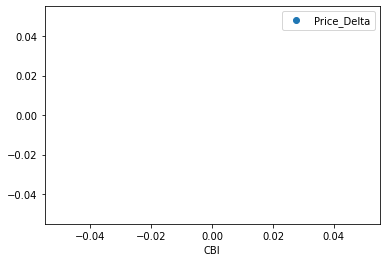

In [15]:
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
print (sp500)
sp500 = sp500[['Symbol','Security','GICS Sector']]
# sp500 = sp500.head(5)

# filename = 'constituents_csv.csv'
# sp500 = pd.read_csv(filename)
# sp500['CBI_RSI']= np.nan
sp500['CBI_SS']= np.nan
sp500['CBI_MACD']= np.nan
sp500['CBI'] = np.nan
sp500['t-30price'] = np.nan
sp500['Price_Delta'] = np.nan
sp500['Trade_Date'] = np.nan
sp500 = sp500[sp500['Symbol'] != "."]
# sp500 = sp500.head(100)

# sp500.groupby(['GICS Sector']).count()
# df2['CBI'] = CBI_func(df2['Symbol'],start_time,end_time)

# start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

#
sector_list = list(sp500['GICS Sector'].unique())
#ticker_list = list(sp500['Symbol'])
passed_tickers=[]
no_data_tickers = []
for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
      try:
        CBIL = CBI_func(ticker, start_time, end_time,30,3,7)

        if len(CBIL) > 0:
          sp500.loc[sp500['Symbol'] == ticker, ['Trade_Date','CBI_SS','CBI_MACD','CBI','t-30price','Price_Delta']] = [CBIL[0], CBIL[1], CBIL[2], CBIL[5],CBIL[3],CBIL[4]]
        
      except:
        print('Analyzed Security: ',ticker, 'No Data')
        no_data_tickers.append(ticker)
        continue


#print("CBI = ", CBI_all)
print(sp500)
print('Tickers Qualified by CBI Criteria: ', passed_tickers)
print('Tickers for which data was not obtained: ', no_data_tickers)
sp500.plot(x='CBI',y='Price_Delta',style='o')

In [17]:
# print("\n\n------- QUALIFIED BY RSI -----------")
# print(sp500[sp500['CBI_RSI'] < 0.25])

print("\n\n------- QUALIFIED BY SS -----------")
print(sp500[sp500['CBI_SS'] < 0.25])

print("\n\n------- QUALIFIED BY MACD -----------")
print(sp500[sp500['CBI_MACD'] < 0.25])

print("\n\n------- QUALIFIED BY CBI -----------")
print(sp500[sp500['CBI'] < 0.25])




------- QUALIFIED BY SS -----------
Empty DataFrame
Columns: [Symbol, Security, GICS Sector, CBI_SS, CBI_MACD, CBI, t-30price, Price_Delta, Trade_Date]
Index: []


------- QUALIFIED BY MACD -----------
Empty DataFrame
Columns: [Symbol, Security, GICS Sector, CBI_SS, CBI_MACD, CBI, t-30price, Price_Delta, Trade_Date]
Index: []


------- QUALIFIED BY CBI -----------
Empty DataFrame
Columns: [Symbol, Security, GICS Sector, CBI_SS, CBI_MACD, CBI, t-30price, Price_Delta, Trade_Date]
Index: []
